In [1]:
import numpy as np
from PIL import Image
import os
import string
import matplotlib.pyplot as plt
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm #to check loop progress
import tensorflow as tf
tqdm().pandas()

C:\Users\Rahul S\AppData\Local\Temp\ipykernel_22052\3935229093.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [2]:
# Load the document file into memory
def load_fp(filename):
  # Open file to read
  file = open(filename, 'r')
  text = file.read()
  file.close()
  return text
# get all images with their captions
def img_capt(filename):
  file = load_fp(filename)
  captions = file.split('\n')
  descriptions ={}
  for caption in captions[:-1]:
    #print(caption)
    img, caption = caption.split('\t')
    #print(img,caption)
    if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
    else:
            descriptions[img[:-2]].append(caption)
  return descriptions
#Data cleaning function will convert all upper case alphabets to lowercase, removing punctuations and words containing numbers
def txt_clean(captions):
  table = str.maketrans('','',string.punctuation)
  for img,caps in captions.items():
    for i,img_caption in enumerate(caps):
              img_caption.replace("-"," ")
              descp = img_caption.split()
              #uppercase to lowercase
              descp = [wrd.lower() for wrd in descp]
              #remove punctuation from each token
              descp = [wrd.translate(table) for wrd in descp]
              #remove hanging 's and a
              descp = [wrd for wrd in descp if(len(wrd)>1)]
              #remove words containing numbers with them
              descp = [wrd for wrd in descp if(wrd.isalpha())]
              #converting back to string
              img_caption = ' '.join(descp)
              captions[img][i]= img_caption
  return captions
def txt_vocab(descriptions):
  # To build vocab of all unique words
  vocab = set()
  for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
  return vocab
#To save all descriptions in one file
def save_descriptions(descriptions, filename):
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(key + '\t' + desc )
      data = "\n".join(lines)
  file = open(filename,"w")
  file.write(data)
  file.close()

In [5]:
# Set these path according to project folder in you system, like i create a folder with my name shikha inside D-drive
dataset_text = "Flickr8k_text"
dataset_images = "Flicker8k_Dataset"
#to prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#map them into descriptions dictionary 
descriptions = img_capt(filename)
print("Length of descriptions =" ,len(descriptions))
#cleaning the descriptions
clean_descriptions = txt_clean(descriptions)
#to build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
#saving all descriptions in one file
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


In [4]:
def extract_features(directory):
    model = Xception( include_top=False, pooling='avg' )
    features = {}
    print(os.listdir(directory))
    for pic in tqdm(os.listdir(directory)):
        file = directory + "/" + pic
        image = Image.open(file)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0)
        #image = preprocess_input(image)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        #print(feature,image)
        features[pic] = feature
    return features
#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))
#to directly load the features from the pickle file.
features = load(open("features.p","rb"))
print(len(features))



83683744/83683744 [==============================] - 9s 0us/step
['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg', '1002674143_1b742ab4b8.jpg', '1003163366_44323f5815.jpg', '1007129816_e794419615.jpg', '1007320043_627395c3d8.jpg', '1009434119_febe49276a.jpg', '1012212859_01547e3f17.jpg', '1015118661_980735411b.jpg', '1015584366_dfcec3c85a.jpg', '101654506_8eb26cfb60.jpg', '101669240_b2d3e7f17b.jpg', '1016887272_03199f49c4.jpg', '1019077836_6fc9b15408.jpg', '1019604187_d087bf9a5f.jpg', '1020651753_06077ec457.jpg', '1022454332_6af2c1449a.jpg', '1022454428_b6b660a67b.jpg', '1022975728_75515238d8.jpg', '102351840_323e3de834.jpg', '1024138940_f1fefbdce1.jpg', '102455176_5f8ead62d5.jpg', '1026685415_0431cbf574.jpg', '1028205764_7e8df9a2ea.jpg', '1030985833_b0902ea560.jpg', '103106960_e8a41d64f8.jpg', '103195344_5d2dc613a3.jpg', '103205630_682ca7285b.jpg', '1032122270_ea6f0beedb.jpg', '1032460886_4a598ed535.jpg', '1034276567_49bb87c51c.jpg', '104136873_5b5d41be75.jpg', '1042020065_

C:\Users\Rahul S\AppData\Local\Temp\ipykernel_25368\337983866.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for pic in tqdm(os.listdir(directory)):


  0%|          | 0/8101 [00:00<?, ?it/s]

1/1 [==============================] - 0s 57ms/step
8101


In [6]:
#load the data
def load_photos(filename):
    file = load_fp(filename)
    photos = file.split("\n")[:-1]
    #print(photos)
    return photos
def load_clean_descriptions(filename, photos):
    #loading clean_descriptions
    file = load_fp(filename)
    descriptions = {}
    #print(file[0:100])
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                    descriptions[image] = []
                    desc = ' ' + " ".join(image_caption) + ' '
                    #print(desc)
                    descriptions[image].append(desc)
    return descriptions
def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [7]:
#convert dictionary to clear list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
#creating tokenizer class
#this will vectorise text corpus
#each integer will represent token in dictionary
from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(descriptions)
dump(tokenizer, open('tokenizer1.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)#The size of our vocabulary is 7577 words.
#calculate maximum length of descriptions to decide the model structure parameters.
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
max_length = max_length(descriptions)
#print(type(max_length))
#Max_length #Max_length of description is 32

8764


In [8]:
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
                #retrieve photo features
                feature = features[key][0]
                inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
                #print(inp_image.shape,inp_seq.shape,op_word.shape)
                yield [[inp_image, inp_seq], op_word]
def create_sequences(tokenizer, max_length, desc_list, feature):
    x_1, x_2, y = list(), list(), list()
    # move through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # divide one sequence into various X,y pairs
        for i in range(1, len(seq)):
                # divide into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                x_1.append(feature)
                x_2.append(in_seq)
                y.append(out_seq)
    return np.array(x_1), np.array(x_2), np.array(y)
#To check the shape of the input and output for your model
#[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
#print(a.shape, b.shape, c.shape)
#((47, 2048), (47, 32), (47, 7577))

In [9]:
from keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model compressed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # merge it [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    #print(model.summary())
    #plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [10]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# creating a directory named models to save our models
os.mkdir("models")
for i in range(epochs):
   generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
   model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
   if i==9:
      model.save("models/model_" + str(i) + ".h5")

Dataset:  5998
Descriptions: train= 5998
Photos: train= 5998
Vocabulary Size: 8764
Description Length:  32



C:\Users\Rahul S\AppData\Local\Temp\ipykernel_25368\3855901924.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)



5998/5998 [==============================] - 151s 25ms/step - loss: 3.1180


c:\Workplace\Python\ImageCaptioning\virenv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 1s/step
dog is running through the grass


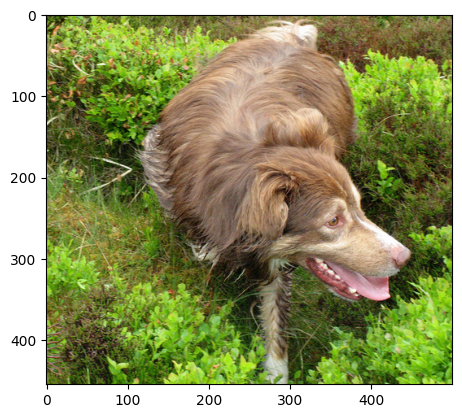

In [6]:
img_path ="C:\Workplace\Python\ImageCaptioning\Flicker8k_Dataset\\494792770_2c5f767ac0.jpg"
stopwords = "a, an, and, are, as, at, be, but, by, others, for, if, in, into, while, is, it, no, not, down, of, on, or, such, that, the, their, then, there, blowing, these, they, this, to, was, will, with, in, his, its"
stopwords = stopwords.split(", ")
#print(stopwords)
def extract_features(filename, model):
    try:
            image = Image.open(filename)
    except:
            print("ERROR: Can't open image! Ensure that image path and extension is correct")
    image = image.resize((299,299))
    image = np.array(image)
    # for 4 channels images, we need to convert them into 3 channels
    if image.shape[2] == 4:
            image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = ''
    for i in range(32):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        #print(word)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
max_length = 32
tokenizer = load(open("tokenizer2.p","rb"))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
#print(description)
hsh = []
op=""
def remove_dup_word(string):
    # Used to split string around spaces.
    words = string.split()
     
    # To store individual visited words
    
    #print("Caption:")
    # Traverse through all words
    i=0
    for word in words:
        # If current word is not seen before.
        if word not in hsh and i<5:
            #print(word, end=" ")
            hsh.append(word)
            i+=1
            continue
        
        #print(word,end=" ")
        hsh.append(word)
        if word in stopwords:
            continue
        else: break

    

remove_dup_word(description)
#print(hsh)
text = ' '.join([str(element) for element in hsh])
print(text)
plt.imshow(img)

In [47]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
#nltk.download('stopwords')
# Your input text goes here
text = ' '.join([str(element) for element in hsh])
print(text)
# Step 1: Import required libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

# Step 2: Remove stop words and store them in a separate array
stopWords = set(stopwords.words("english"))
words = word_tokenize(text)

# Step 3: Create a frequency table of words
freqTable = dict()
for word in words:
    word = word.lower()
    if word not in stopWords:
        if word in freqTable:
            freqTable[word] += 1
        else:
            freqTable[word] = 1

# Step 4: Assign scores to each sentence based on word frequency
sentences = sent_tokenize(text)
sentenceValue = dict()

for sentence in sentences:
    for word, freq in freqTable.items():
        if word in sentence.lower():
            if sentence in sentenceValue:
                sentenceValue[sentence] += freq
            else:
                sentenceValue[sentence] = freq

# Sort sentences by score and select the top ones
sortedSentences = sorted(sentenceValue.items(), key=lambda x: x[1], reverse=True)
numSentences = 3  # You can adjust this to get more or fewer sentences
summary = " ".join([sentence for sentence, _ in sortedSentences[:numSentences]])

print(summary)

jacket is in red
jacket is in red
